Plots winrate of latest KataGo checkpoints,
starting from b40-s11840M (aka cp505)
and going until networks from 2023-03-14
(a few months after adversarial-position-selfplay started).

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from IPython.core.display import HTML
from IPython.display import display
from sgf_parser import game_info
from statsmodels.stats.proportion import proportion_confint

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col"),
    ]
)

### Parse data

In [3]:
df = utils.parse_sgfs(
    [
        "/nas/ucb/tony/go-attack/matches/cyclic-adv-s545m-vs-newer-katago-ckpts/",
        "/nas/ucb/k8/go-attack/match/tony-new-kata-cp-sweep-try0/",
        "/nas/ucb/k8/go-attack/match/tony-new-kata-cp-sweep-v32/",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.1",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.2",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.3.1",
        "/nas/ucb/k8/go-attack/match/tony-adv-v-kata-v2.3.2",
        "/nas/ucb/k8/go-attack/match/tony-advft-v-kata/",
        "/nas/ucb/k8/go-attack/match/ttseng-cyclic-vs-b18-20230516",
    ]
)
df["victim_net_type"] = df.victim_name.str.split("-").str[0]
df["victim_rows"] = (
    df.victim_name.str.split("-v").str[0].str.split("-d").str[-1].astype(int)
)
len(df), df.victim_visits.unique(), df.adv_name.unique(), df.victim_net_type.unique()

(59800,
 array([200,   1,  32]),
 array(['adv-s545065216-v600-AMCTS', 'adv-s22887680-v600-AMCTS'],
       dtype=object),
 array(['b60c320', 'b40c256', 'b18c384nbt'], dtype=object))

In [4]:
# kata1-b60c320-s6729327872-d3057177418 is last checkpoint before
# adversarial training begins
ADV_TRAIN_ROW_START = 3057177418

# Latest - kata1-b40c256-s11840935168-d2898845681 
LATEST_STEPS = 11840935168
LATEST_ROWS = 2898845681

### Plots by steps

In [5]:
def generate_fancy_plots(
    adv_name: str,
    net_types: list[str],
    skip_legend: bool = False,
    custom_xlabel: str | None = None,
    custom_ylabel: str | None = None,
):
    ALPHA = 0.05
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for net_type in net_types:
        for i, vv in enumerate(sorted(df.victim_visits.unique())):
            sub_df = df.query(
                "&".join(
                    [
                        "victim_net_type == @net_type",
                        "victim_visits == @vv",
                        "adv_name == @adv_name",
                    ]
                )
            )
            mean_df = sub_df.groupby("victim_steps").adv_win.mean()

            (100 * mean_df).plot(label=f"KataGo visits: {vv}", color=colors[i])

            # Compute Clopper-Pearson confidence intervals
            ci_df = sub_df.groupby("victim_steps").adv_win.apply(
                lambda x: proportion_confint(
                    x.sum(),
                    len(x),
                    alpha=ALPHA,
                    method="beta",
                )
            )
            ci_df = pd.DataFrame(
                ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
            )
            ci_df = 100 * ci_df
            plt.fill_between(
                mean_df.index,
                ci_df.lower,  # type: ignore
                ci_df.upper,  # type: ignore
                alpha=0.3,
                color=colors[i],
                edgecolor="none",
            )

            if vv == 200 and net_type == "b40c256":
                plt.plot(
                    LATEST_STEPS,
                    100 * sub_df.query("victim_steps == @LATEST_STEPS").adv_win.mean(),
                    "D",
                    label=r"\texttt{Latest}$^\mathrm{200\,visits}$",
                    color="black",
                )

        adv_training_start_steps = df.query(
            "victim_net_type == @net_type & victim_rows <= @ADV_TRAIN_ROW_START"
        ).victim_steps.max()
        if adv_training_start_steps is not np.nan:
            plt.axvline(
                adv_training_start_steps,
                color="black",
                linestyle="--",
                label="Adv. training starts",
            )

        # Legend in lower left corner
        if not skip_legend:
            plt.legend()
        plt.ylabel(
            custom_ylabel
            or (
                r"Cyclic-adv.$^\mathrm{600\,visits}$ win rate \%"
                + ("\n(finetuned adversary)" if "s22887680" in adv_name else "")
            )
        )
        plt.xlabel(
            custom_xlabel
            or rf"KataGo ($\texttt{{{net_type.split('c')[0]}}}$) training steps"
        )


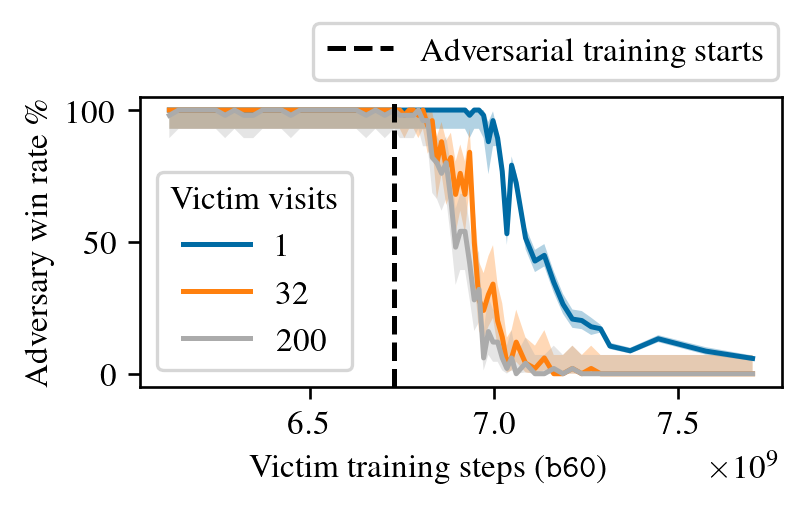

In [6]:
tmp_plot_style = [
    "tableau-colorblind10",
    utils.get_style("default"),
    utils.get_style("2-col"),
    # utils.get_style("small-legend"),
]

with plt.style.context(tmp_plot_style):
    generate_fancy_plots(
        adv_name="adv-s545065216-v600-AMCTS",
        net_types=["b60c320"],
        custom_xlabel=r"Victim training steps (\texttt{b60})",
        custom_ylabel=r"Adversary win rate \%",
    )
    xlabel = plt.gca().get_xaxis().get_label()
    xlabel.set_position((0.45, xlabel.get_position()[1]))

    # Remove last entry from legend
    handles, labels = plt.gca().get_legend_handles_labels()

    # Legend #2 for for visits
    first_legend = plt.legend(
        handles[:-1],
        [l.replace("KataGo visits: ", "") for l in labels[:-1]],
        loc="lower left",
        bbox_to_anchor=(0, 0),
        ncols=1,
        columnspacing=0.7,
        title="Victim visits",
    )
    ax = plt.gca().add_artist(first_legend)

    # Legend #2 for adversarial training line
    plt.legend(
        handles[-1:],
        ["Adversarial training starts"],
        loc="lower right",
        bbox_to_anchor=(1.02, 1),
        # handlelength=1.5,
        # handletextpad=0,
    )

    plt.gcf().set_figheight(plt.gcf().get_figheight() * 1)

    plt.savefig(f"katago-adv-training-win-rate-b60-2col.pgf", backend="pgf")
    plt.show()


In [7]:
sub_df = df.query(
    "&".join(
        [
            "victim_net_type == 'b60c320'",
            "victim_visits == 1",
            "adv_name == 'adv-s545065216-v600-AMCTS'",
        ]
    )
)
sub_df = sub_df[sub_df.victim_steps == sub_df.victim_steps.max()]
sub_df.adv_win.sum(), len(sub_df), sub_df.adv_win.mean()

(119, 2050, 0.05804878048780488)

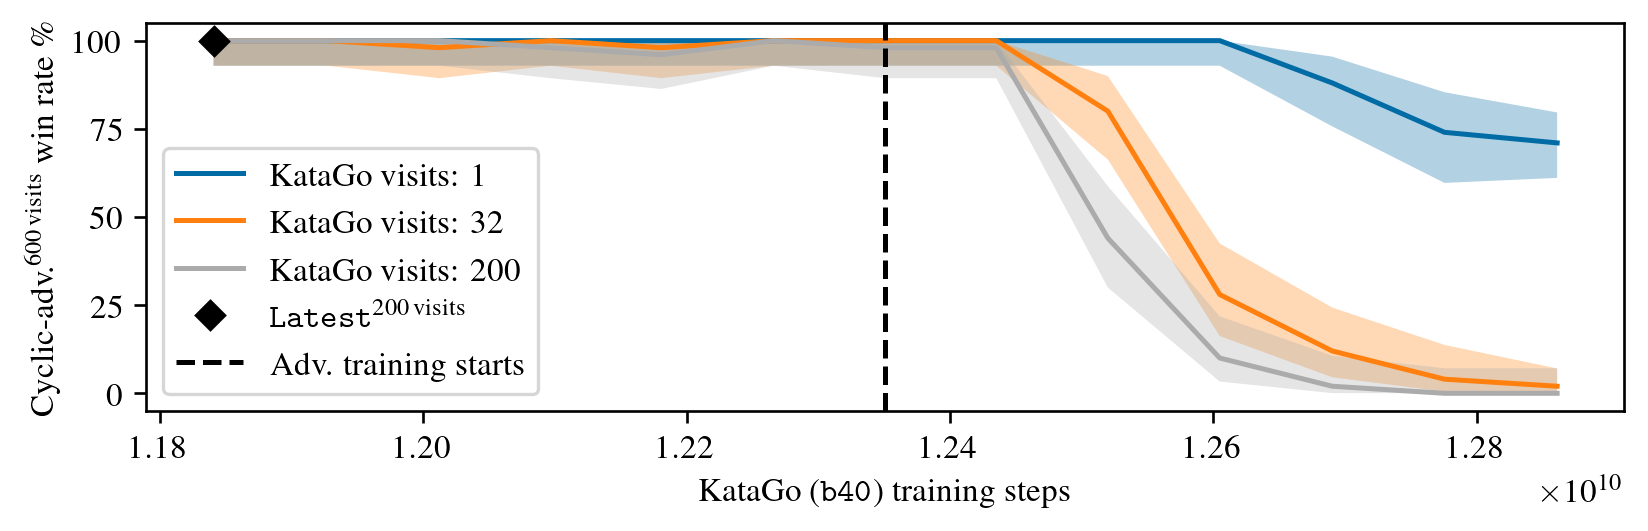

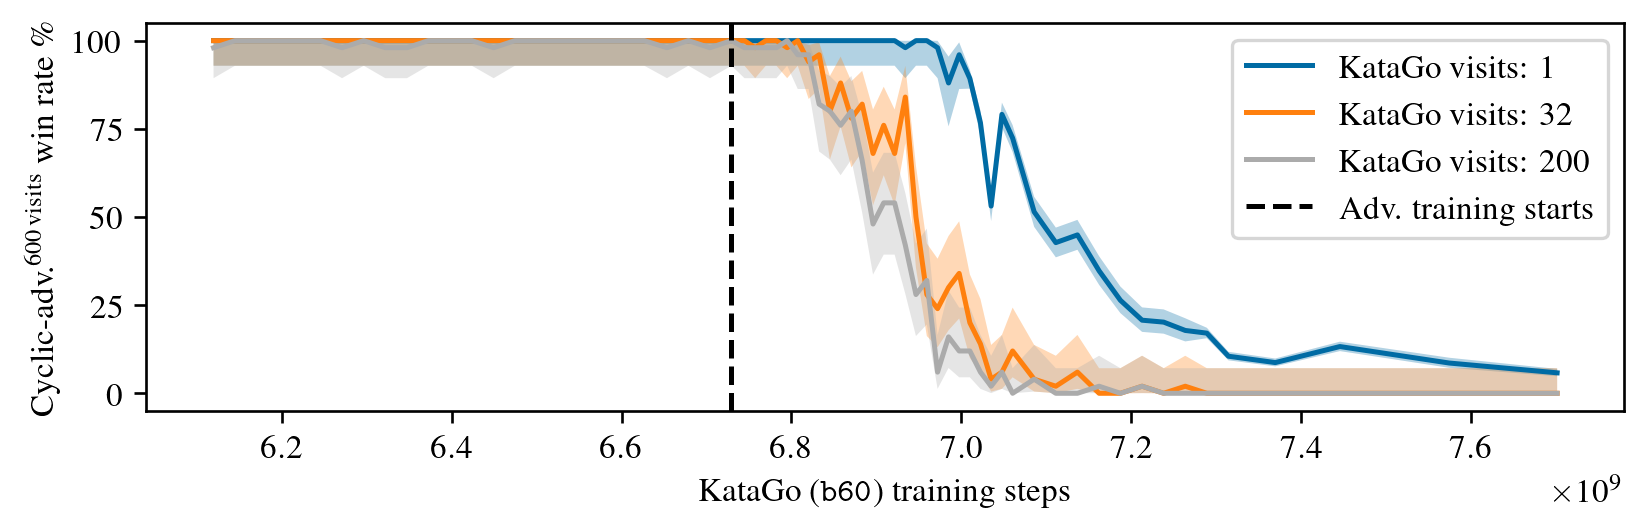

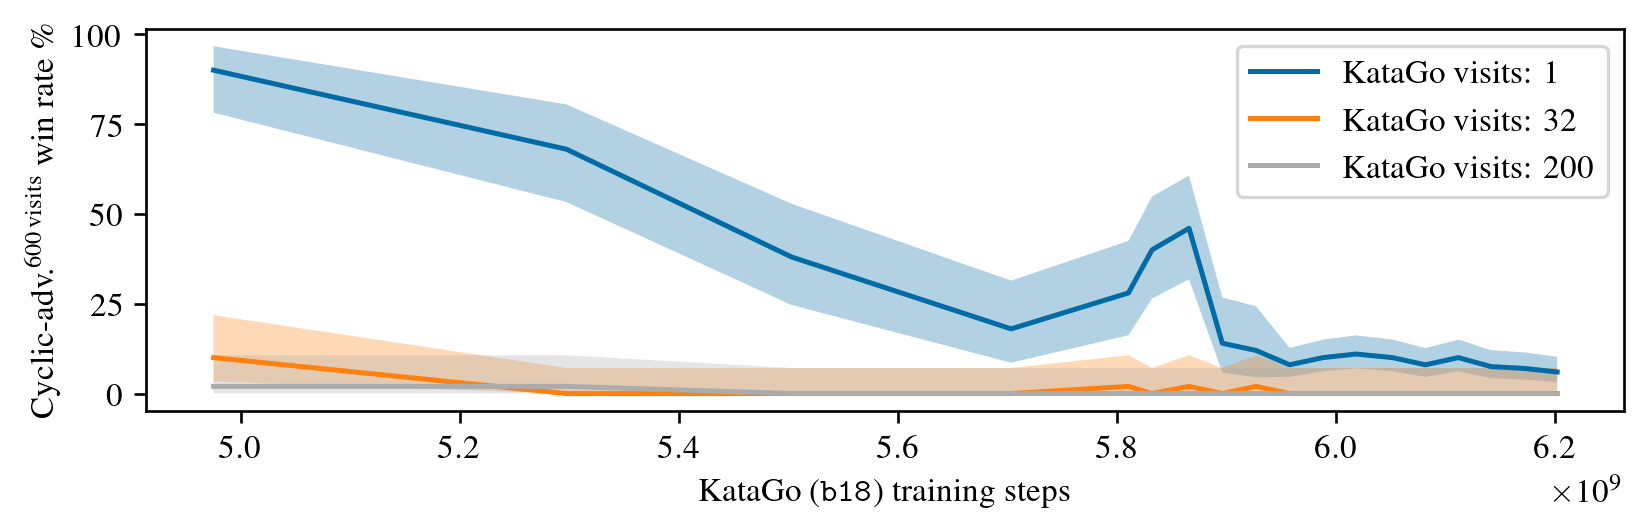

In [8]:
plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

for net_type in ["b40c256", "b60c320", "b18c384nbt"]:
    generate_fancy_plots(
        adv_name="adv-s545065216-v600-AMCTS", net_types=[net_type],
    )
    plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.7)
    plt.savefig(f"katago-adv-training-win-rate-{net_type}.pgf", backend="pgf")
    plt.show()

# generate_fancy_plots(adv_name="adv-s22887680-v600-AMCTS", net_types=["b60c320"])

### Evals over course of finetuning

In [9]:
df_ft = utils.parse_sgfs(
    [
        "/nas/ucb/k8/go-attack/match/tony-ft-eval-sweep",
        "/nas/ucb/k8/go-attack/match/tony-ft-evals-v1.1",
        "/nas/ucb/k8/go-attack/match/tony-ft-evals-v2",
    ]
)
df_ft["adv_orig_steps"] = df_ft.adv_name.str.split("-cs").str[0].str.split("-os").str[-1].astype(int)
df_ft["adv_cml_steps"] = df_ft.adv_name.str.split("-cs").str[-1].astype(int)
len(df_ft)

14200

In [10]:
victim_change_cml_steps = []
for run_dir, offset in zip(
    [
        "ttseng-cyclic-vs-cp564-20230213-154321",
        "tony-cyc-adv-ft-vs-b60-s7702m-20230518-185923",
        "tony-cyc-adv-ft-vs-b60-s7702m-20230520-174057",
    ],
    sorted((df_ft.adv_cml_steps - df_ft.adv_orig_steps).unique()),
):
    steps = utils.get_victim_change_steps(
        utils.parse_sgfs(
            [os.path.join("/nas/ucb/k8/go-attack/victimplay", run_dir, "selfplay")]
        )
    )
    print(steps)

    victim_change_cml_steps.extend([s + offset for s in steps])

print(victim_change_cml_steps)

[0, 8558080, 12211200, 16155392]
[0, 26985728, 34275840]
[0, 1600256, 22809344, 75567360, 87401472, 96528896, 105302272]
[0, 8558080, 12211200, 16155392, 22887680, 49873408, 57163520, 57163520, 58763776, 79972864, 132730880, 144564992, 153692416, 162465792]


In [11]:
df_ft.victim_name

0        b60-7702m
1        b60-7702m
2        b60-7702m
3        b60-7702m
4        b60-7702m
           ...    
14195    b60-7702m
14196    b60-7702m
14197    b60-7702m
14198    b60-7702m
14199    b60-7702m
Name: victim_name, Length: 14200, dtype: object

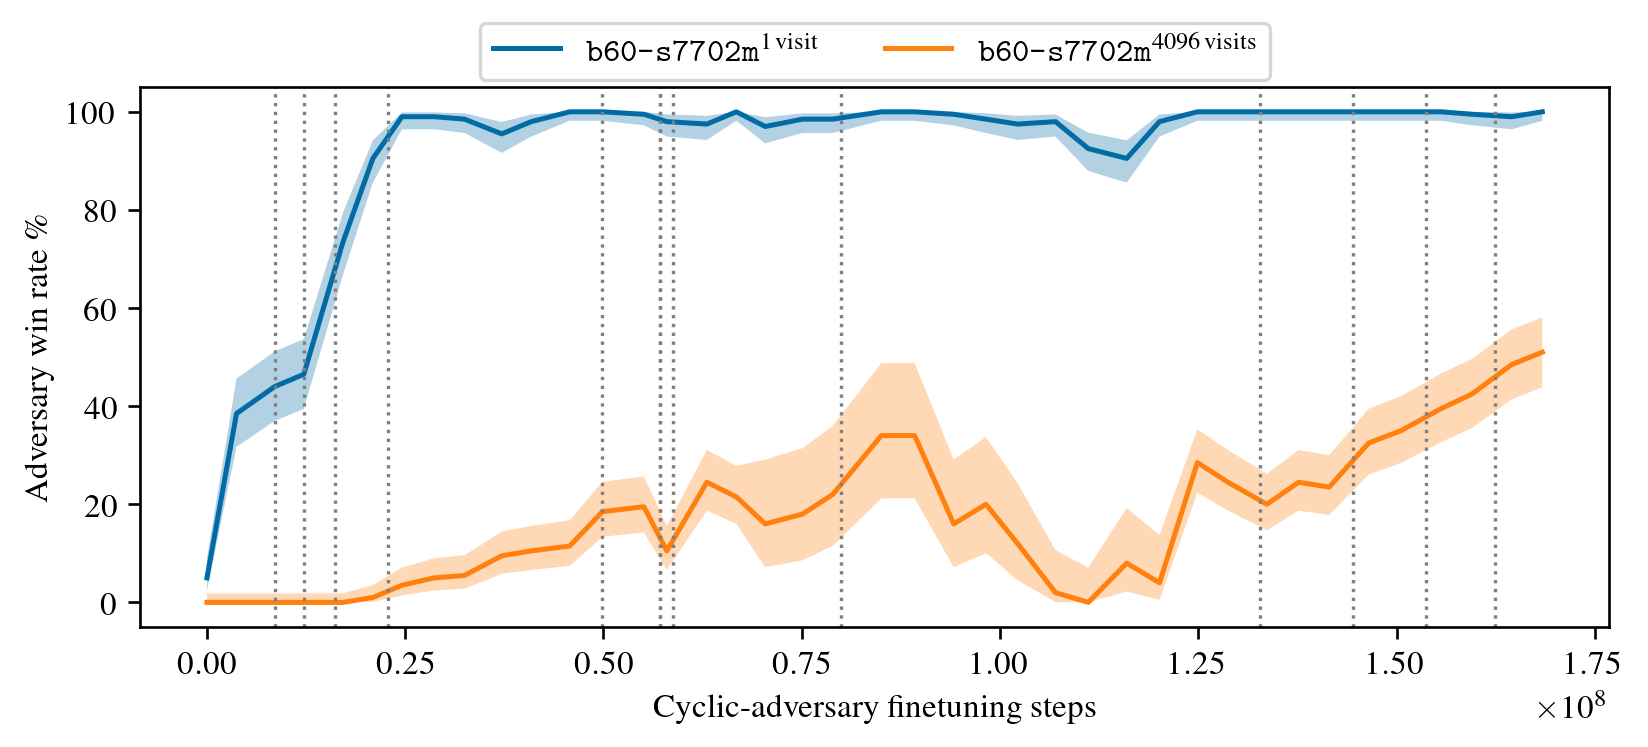

In [12]:
plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)
ALPHA = 0.05

for victim_visits in [1, 4096]:
    sub_df = df_ft.query("victim_visits == @victim_visits")

    mean_df = sub_df.groupby("adv_cml_steps").adv_win.mean()
    visit_suffix = "visits" if victim_visits > 1 else "visit"
    (100 * mean_df).plot(
        label=rf"$\texttt{{b60-s7702m}}^\mathrm{{{victim_visits}\,{visit_suffix}}}$",
    )

    # Compute Clopper-Pearson confidence intervals
    ci_df = sub_df.groupby("adv_cml_steps").adv_win.apply(
        lambda x: proportion_confint(
            x.sum(),
            len(x),
            alpha=ALPHA,
            method="beta",
        )
    )
    ci_df = pd.DataFrame(ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"])
    ci_df = 100 * ci_df
    plt.fill_between(
        mean_df.index,
        ci_df.lower,  # type: ignore
        ci_df.upper,  # type: ignore
        alpha=0.3,
        edgecolor="none",
    )

max_step = max(victim_change_cml_steps)
for xc in victim_change_cml_steps:
    if xc > 0:
        plt.axvline(x=xc, linestyle=":", linewidth=1, color="tab:gray")

plt.xlabel("Cyclic-adversary finetuning steps")
plt.ylabel("Adversary win rate \%")

# Legend on top of plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.ylim(-5, 105)
plt.savefig(f"adv-finetune-vs-steps.pgf", backend="pgf")
plt.show()


Would be nice in the above plot to have win rates for b60-s7702m-v4096

b60-s7702m-v1: Can show initial improvement on the left things are flatlined against the v4096 victim.

Latest-v4096: demonstrates that our current attack strategy
suffers from catastrophic forgettin, not sure this is core to the paper though.
Also we already have an eval that demonstrates this.

### Plots by datarows

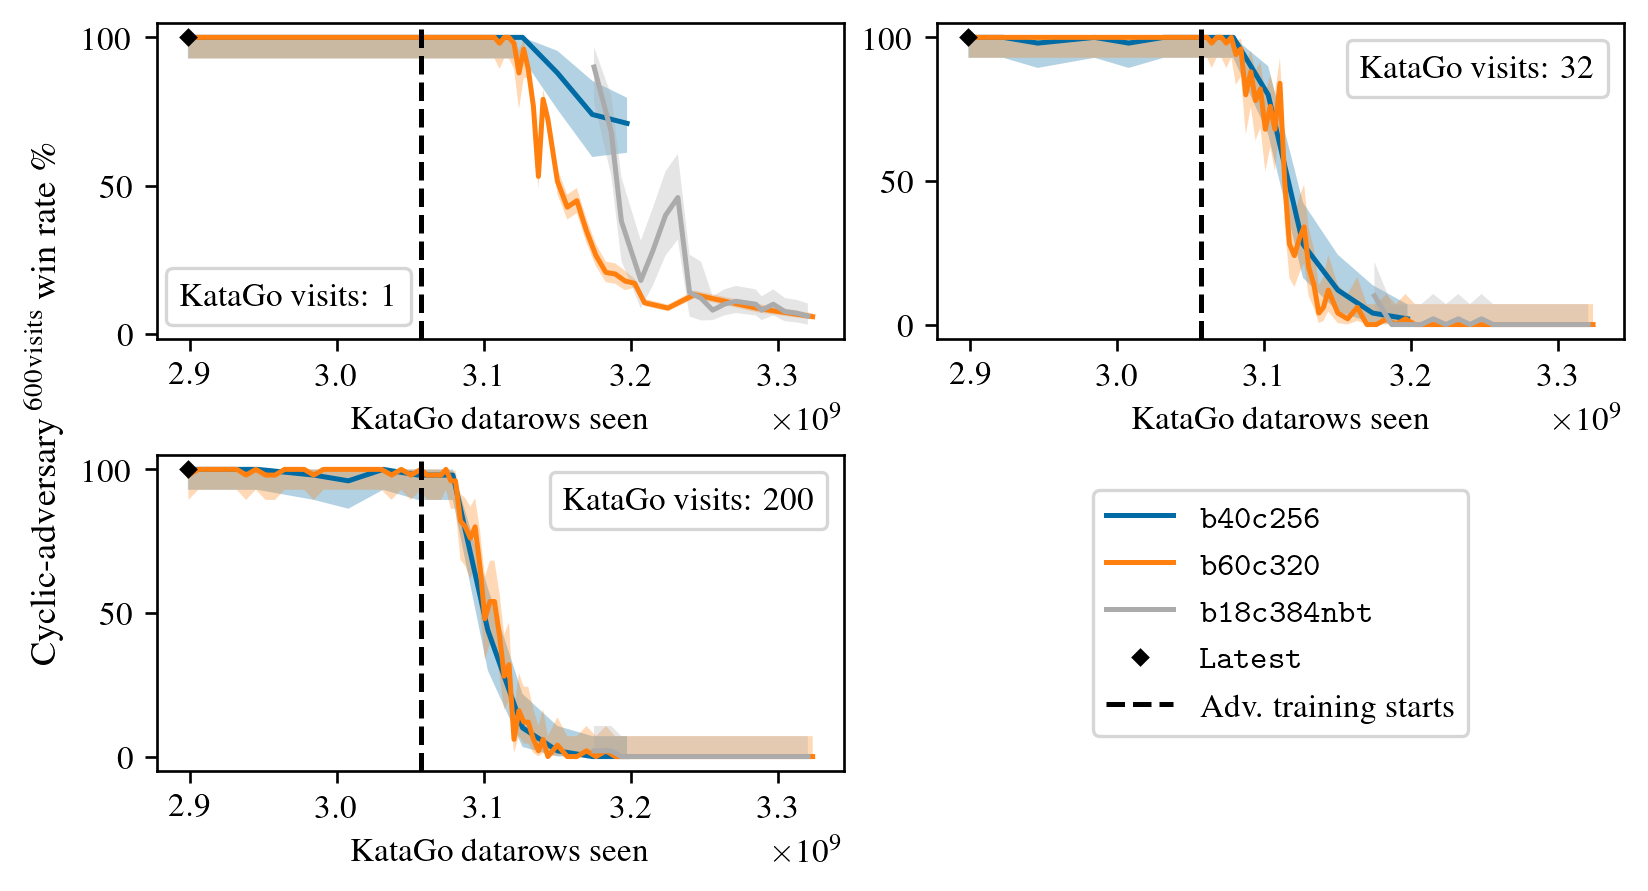

In [13]:
def generate_fancy_row_plots(
    adv_name: str,
    net_types: list[str],
    victim_visits: int,
):
    ALPHA = 0.05
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, net_type in enumerate(net_types):
        sub_df = df.query(
            "&".join(
                [
                    "victim_net_type == @net_type",
                    "victim_visits == @victim_visits",
                    "adv_name == @adv_name",
                ]
            )
        )
        mean_df = sub_df.groupby("victim_rows").adv_win.mean()

        (100 * mean_df).plot(label=fr"\texttt{{{net_type}}}", color=colors[i])

        # Compute Clopper-Pearson confidence intervals
        ci_df = sub_df.groupby("victim_rows").adv_win.apply(
            lambda x: proportion_confint(
                x.sum(),
                len(x),
                alpha=ALPHA,
                method="beta",
            )
        )
        ci_df = pd.DataFrame(
            ci_df.tolist(), index=ci_df.index, columns=["lower", "upper"]
        )
        ci_df = 100 * ci_df
        plt.fill_between(
            mean_df.index,
            ci_df.lower,  # type: ignore
            ci_df.upper,  # type: ignore
            alpha=0.3,
            color=colors[i],
            edgecolor="none",
        )

        if net_type == "b40c256":
            plt.plot(
                LATEST_ROWS,
                100 * sub_df.query("victim_rows == @LATEST_ROWS").adv_win.mean(),
                "D",
                label=r"\texttt{Latest}",
                color="black",
                # set size
                markersize=3,
                zorder=10,
            )

    plt.axvline(
        ADV_TRAIN_ROW_START,
        color="black",
        linestyle="--",
        label="Adv. training starts",
    )

    plt.xlabel(rf"KataGo datarows seen")


adv_name = "adv-s545065216-v600-AMCTS"
for i, victim_visits in enumerate([1, 32, 200]):
    plt.subplot(2, 2, i + 1)
    generate_fancy_row_plots(
        adv_name=adv_name,
        net_types=["b40c256", "b60c320", "b18c384nbt"],
        victim_visits=victim_visits,
    )
    # Empty legend in upper right corner with just a title
    # Plot dummy line to get handle
    line, = plt.plot([], [], label="", color="white")
    plt.legend(
        [line],
        [f"KataGo visits: {victim_visits}"],
        loc="lower left" if i == 0 else "upper right",
        frameon=True,
        bbox_to_anchor=(-0.01, -0.01) if i == 0 else (1, 1),
        handlelength=0,
        handletextpad=0,
    )

# Make one legend for all plots
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
handles, labels = list(by_label.values()), list(by_label.keys())
legend_perm = [0, 2, 3, 1, 4]
handles = [handles[i] for i in legend_perm]
labels = [labels[i] for i in legend_perm]

plt.subplot(2, 2, 4)
plt.axis("off")
plt.legend(
    handles,
    labels,
    loc="center",
    bbox_to_anchor=(0.5, 0.5),
)

# Set y label for all plots
plt.gcf().set_figheight(plt.gcf().get_figheight() * 1.2)
ylabel = plt.gcf().supylabel(
    r"Cyclic-adversary\,$^\mathrm{600\,visits}$ win rate \%"
    + ("\n(finetuned adversary)" if "s22887680" in adv_name else ""),
    fontsize=11,
)
ylabel.set_position((0, 0.55))

plt.savefig(f"katago-adv-training-grouped.pgf", backend="pgf")
plt.show()

### Study games

In [14]:
def display_link(link: str, text: str = "Link to game"):
    display(HTML(f'<a href="{link}">{text}</a>'))

In [15]:
sorted(df.query("victim_net_type == 'b60c320'").victim_steps.unique())[-5:]

[7314725888, 7369871872, 7445994752, 7574764800, 7701878528]

In [16]:
plt.figure(figsize=(20, 2))
plt.suptitle("adv_minus_victim_score, b60c320, 1 visit")
for i, steps in enumerate([7314725888, 7369871872, 7445994752, 7574764800, 7701878528]):
    plt.subplot(1, 5, i + 1)
    sub_df = df.query(
        "&".join(
            [
                "victim_net_type == 'b60c320'",
                "victim_steps == @steps",
                "victim_visits == 1",
                "adv_name == 'adv-s545065216-v600-AMCTS'",
            ]
        )
    )
    sub_df.adv_minus_victim_score.hist()
    plt.title(f"{steps=}")

In [17]:
sub_df = df.query(
    "&".join(
        [
            "victim_net_type == 'b60c320'",
            "victim_steps == 7701878528",
            "victim_visits == 200",
            "adv_name == 'adv-s22887680-v600-AMCTS'",
        ]
    )
)

print("Winning games")
for row in list(sub_df.query("adv_win").itertuples())[:5]:
    display_link(game_info.get_viz_link(row.sgf_path, row.sgf_line))

print("Losing games")
for row in list(sub_df.query("~adv_win").itertuples())[:5]:
    display_link(game_info.get_viz_link(row.sgf_path, row.sgf_line))

Winning games


Losing games
